In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch

In [2]:
import h5py
Lab1_MNIST = h5py.File('MNISTdata.hdf5','r') # Loading the h5py file
data_in=np.array(Lab1_MNIST['input']) #converting the file to numpy array (input data)
data_out=np.array(Lab1_MNIST['output']) #converting the file to numpy array (output data)
print(data_in.shape) 
print(data_out.shape)

(2000, 28, 28, 1)
(2000, 1)


In [3]:
# splitting the data into 70 % and 30% testing
train_X,test_X, train_y, test_y = train_test_split(data_in,data_out,test_size=0.3,random_state=21)
print(train_X.shape)
print(test_X.shape)
print(train_y.shape)
print(test_y.shape)

(1400, 28, 28, 1)
(600, 28, 28, 1)
(1400, 1)
(600, 1)


In [4]:
#reshaping the input data as (2000,784) and output data as column of 2000
X_train=train_X.reshape(-1,784)
X_test=test_X.reshape(-1,784)
y_train=train_y.reshape(1400)
y_test=test_y.reshape(600)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
# coverting numpy array to tensor and datatype float(for input) and integer for output
X_train=torch.FloatTensor(X_train)
X_test=torch.FloatTensor(X_test)
y_train=torch.LongTensor(y_train)
y_test=torch.LongTensor(y_test)

(1400, 784)
(600, 784)
(1400,)
(600,)


In [5]:
#zipping the input data X and labels y together for test data and train data separately
train_data= list(zip(X_train,y_train))
test_data = list(zip(X_test,y_test))

In [6]:
# Loading data in batches of 64 size
trainloader = DataLoader(train_data, batch_size=64, shuffle=True)
testloader = DataLoader(test_data,batch_size=64, shuffle=False)
for images, labels in trainloader:
    print('Batch shape:', images.size())
    break

Batch shape: torch.Size([64, 784])


In [7]:
# Creating a model class
class Model_1(nn.Module):
    def __init__(self,in_features=784,h1 = 400,h2=200, out_features=10):
        super().__init__()
        self.fc1 = nn.Linear(in_features,h1) # input layer
        self.fc2 = nn.Linear(h1,h2)          # hidden layer of required number of units
        self.out = nn.Linear(h2,out_features)
    
    # Using model in a given sequecnce one after the other
    def forward(self,x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.out(x)
        
        return F.log_softmax(x,dim=1)
torch.manual_seed(30)
model_1 = Model_1()
model_1

Model_1(
  (fc1): Linear(in_features=784, out_features=400, bias=True)
  (fc2): Linear(in_features=400, out_features=200, bias=True)
  (out): Linear(in_features=200, out_features=10, bias=True)
)

In [8]:
# Printing the number of parameters i the model
for item in model_1.parameters():
    print(item.numel()) 

313600
400
80000
200
2000
10


In [9]:
# Defining loss and optimizers as mentioned in the problem statement
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_1.parameters(),lr=1e-3,weight_decay=1e-4)

In [10]:
# Training the model with 100 epochs
import time
start_time = time.time()
epoch=10
trn_loss1=[]
tst_loss1=[]
tst_corr = []
trn_corr = []
for i in range(epoch):
    num_tst_corr = 0
    num_trn_corr = 0
    for b,(X_tr,y_tr) in enumerate(trainloader):
        b+=1
        y_predicted = model_1(X_tr)
        trnl_1=loss(y_predicted,y_tr)
        
        predicted = torch.max(y_predicted.data, 1)[1]    # this calculates the index of maximum value in one hot vector
        batch_corr = (predicted == y_tr).sum()   # this compares target value with model prediction
        num_trn_corr += batch_corr                  # summing up number of correct predictions by the model
        
        optimizer.zero_grad()
        trnl_1.backward()
        optimizer.step()
    
    trn_loss1.append(trnl_1.item())    
    if i%1==0:
        print(f' epoch: {i+1}     train_loss: {trnl_1.item()}')
    
    trn_corr.append(num_trn_corr)
    
    # Cecking the model for the test data (this part is not the par tof backward computation so without gradient)
    with torch.no_grad():
        for c,(X_tst,y_tst) in enumerate(testloader):
            c+=1
            y_val = model_1(X_tst)
            tstl_1=loss(y_val,y_tst)
            
            pred = torch.max(y_val.data, 1)[1]
            batch_corr_test = (pred == y_tst).sum()
            num_tst_corr += batch_corr_test
            
        tst_loss1.append(tstl_1.item())
        if i%1==0:
            print(f' epoch: {i+1}     test_loss: {tstl_1.item()}')
    tst_corr.append(num_tst_corr)
    
end_time = time.time()
total_time = end_time - start_time
print(f'total time: {total_time}')

 epoch: 1     train_loss: 0.9360163807868958
 epoch: 1     test_loss: 1.2554651498794556
 epoch: 2     train_loss: 0.239603191614151
 epoch: 2     test_loss: 0.8210561275482178
 epoch: 3     train_loss: 0.06418658792972565
 epoch: 3     test_loss: 0.5839741826057434
 epoch: 4     train_loss: 0.024469098076224327
 epoch: 4     test_loss: 0.5005155205726624
 epoch: 5     train_loss: 0.007719057146459818
 epoch: 5     test_loss: 0.40005579590797424
 epoch: 6     train_loss: 0.0018318543443456292
 epoch: 6     test_loss: 0.4692899286746979
 epoch: 7     train_loss: 0.005678094923496246
 epoch: 7     test_loss: 0.44723233580589294
 epoch: 8     train_loss: 0.0027228754479438066
 epoch: 8     test_loss: 0.4682929515838623
 epoch: 9     train_loss: 0.0017223661998286843
 epoch: 9     test_loss: 0.4663386046886444
 epoch: 10     train_loss: 0.0007047397084534168
 epoch: 10     test_loss: 0.46677589416503906
total time: 4.214588403701782


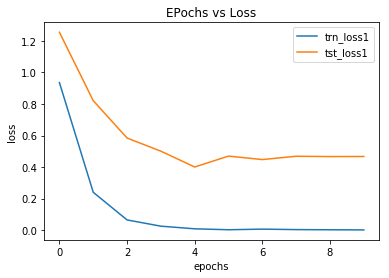

In [11]:
plt.plot(range(epoch),trn_loss1,label='trn_loss1')
plt.plot(range(epoch),tst_loss1,label='tst_loss1')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title("EPochs vs Loss")
plt.legend()

In [12]:
# Accuracy of 1400 training data over each epoch in percentage
l_trn_accurate=[]
for i in trn_corr:
    l_trn_accurate.append(float(f'{i.item()/14:.2f}'))
print(l_trn_accurate)

[60.14, 88.43, 96.29, 99.36, 99.64, 99.93, 100.0, 100.0, 100.0, 100.0]


In [13]:
# Number of correct predictions out of 600 test data over each epoch
l_tst_accurate=[]
for i in tst_corr:
    l_tst_accurate.append(float(f'{i.item()/6:.2f}'))
print(l_tst_accurate)

[78.17, 82.5, 89.67, 90.83, 90.33, 90.83, 90.0, 90.17, 90.0, 90.0]


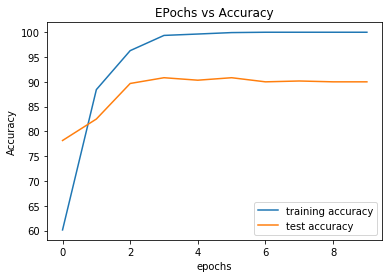

In [14]:
# Comparing the training accuracy and test accuracy
plt.plot(range(epoch),(l_trn_accurate),label='training accuracy')
plt.plot(range(epoch),(l_tst_accurate),label='test accuracy')
plt.xlabel('epochs')
plt.ylabel('Accuracy')
plt.title("EPochs vs Accuracy")
plt.legend()